In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

from pymc_marketing.mmm.builders.yaml import build_from_yaml

warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X = pd.read_csv("../../../../data/processed/X.csv")
y = pd.read_csv("../../../../data/processed/y.csv")

In [3]:
X.head(3)

,date,market,channel_1,channel_2
0,2023-01-01,US,70.171496,20.945956
1,2023-01-02,US,90.243918,45.828916
2,2023-01-03,US,9.178717,26.322735


In [4]:
y.head(3)

,kpi_registrations
0,45.453806
1,42.516346
2,54.250939


## Simple model

In [5]:
mmm = build_from_yaml(
    X=X, y=y, config_path="../../../../data/config_files/basic_model.yml"
)

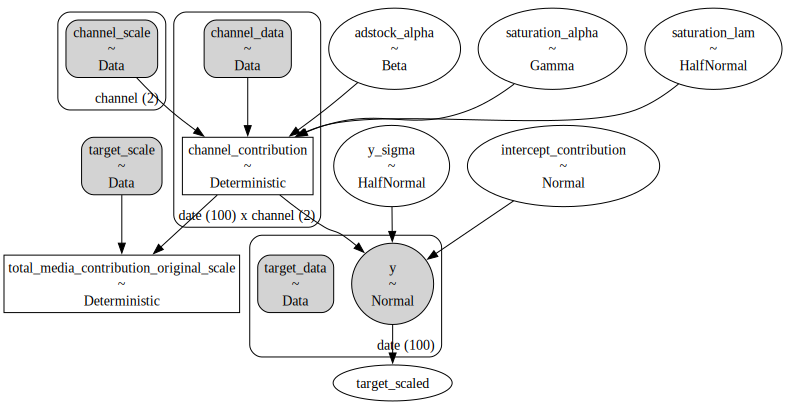

In [6]:
mmm.model.to_graphviz()

In [7]:
prior_predictive = mmm.sample_prior_predictive(X=X, y=y, samples=1_000)

Sampling: [adstock_alpha, intercept_contribution, saturation_alpha, saturation_lam, y, y_sigma]


In [8]:
prior_predictive

<xarray.Dataset> Size: 828kB
Dimensions:  (date: 100, sample: 1000)
Coordinates:
  * date     (date) <U10 4kB '2023-01-01' '2023-01-02' ... '2023-04-10'
  * sample   (sample) object 8kB MultiIndex
  * chain    (sample) int64 8kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 800kB 4.05 -1.709 -0.02521 ... 4.576 -2.924
Attributes:
    created_at:                 2025-05-05T13:36:41.711925+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0
    pymc_marketing_version:     0.13.1

## Multi Dimensional model

In [9]:
mmm2 = build_from_yaml(
    X=X, y=y, config_path="../../../../data/config_files/multi_dimensional_model.yml"
)

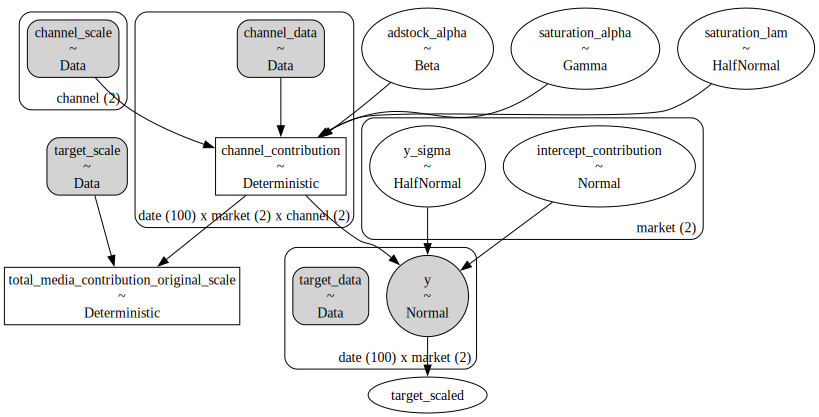

In [10]:
mmm2.model.to_graphviz()

In [11]:
prior_predictive = mmm2.sample_prior_predictive(X=X, y=y, samples=1_000)

Sampling: [adstock_alpha, intercept_contribution, saturation_alpha, saturation_lam, y, y_sigma]


## Multidimensional Hierarchical Model

In [12]:
mmm3 = build_from_yaml(
    X=X,
    y=y,
    config_path="../../../../data/config_files/multi_dimensional_hierarchical_model.yml",
)

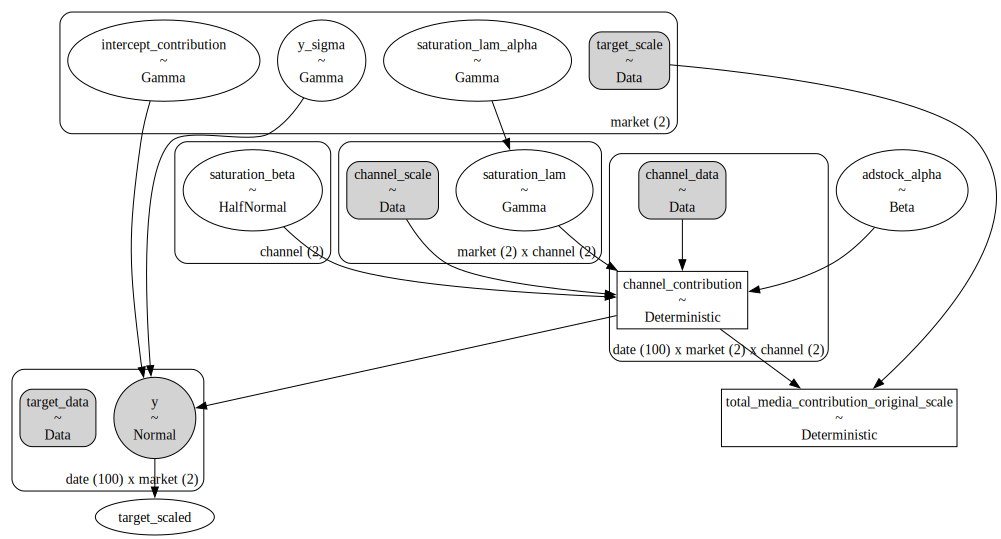

In [13]:
mmm3.model.to_graphviz()

In [14]:
prior_predictive = mmm3.sample_prior_predictive(X=X, y=y, samples=1_000)

Sampling: [adstock_alpha, intercept_contribution, saturation_beta, saturation_lam, saturation_lam_alpha, y, y_sigma]


## Multidimensional Hierarchical with arbitrary effects

In [15]:
mmm4 = build_from_yaml(
    X=X,
    y=y,
    config_path="../../../../data/config_files/multi_dimensional_hierarchical_with_arbitrary_effects_model.yml",
)

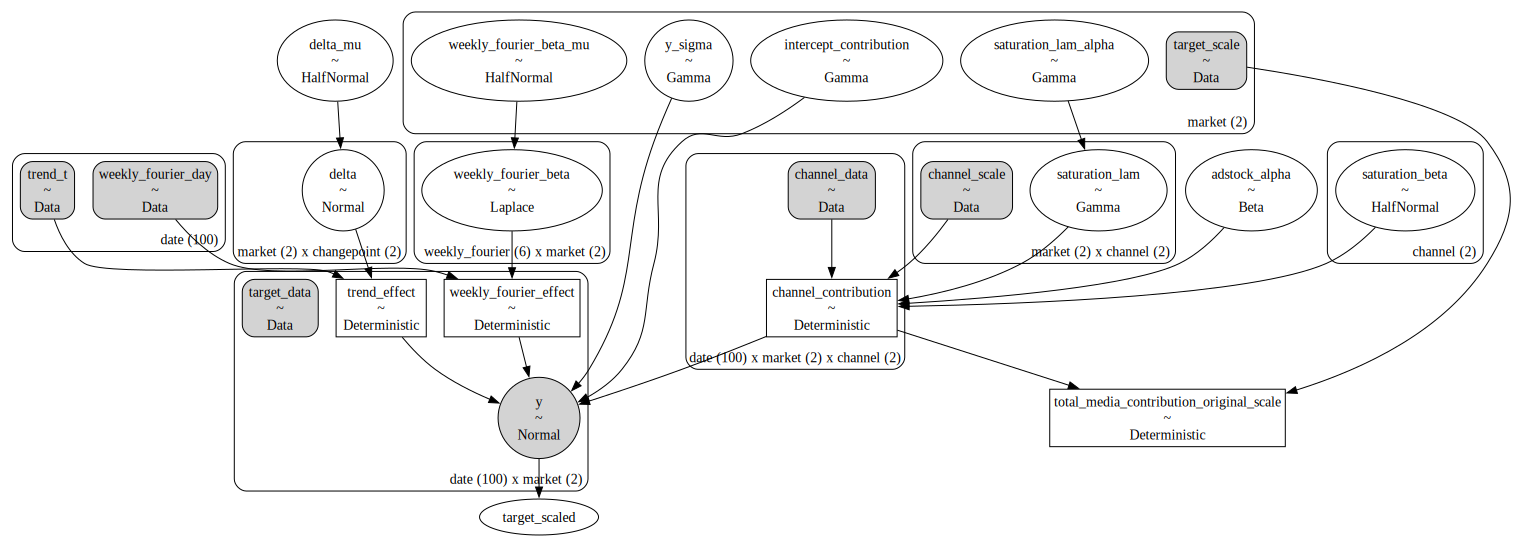

In [16]:
mmm4.model.to_graphviz()

In [17]:
prior_predictive = mmm4.sample_prior_predictive(X=X, y=y, samples=1_000)

Sampling: [adstock_alpha, delta, delta_mu, intercept_contribution, saturation_beta, saturation_lam, saturation_lam_alpha, weekly_fourier_beta, weekly_fourier_beta_mu, y, y_sigma]
